In [1]:
import torch
from torch import nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import json
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import FashionMNIST
from tqdm.auto import tqdm


torch.manual_seed(0)

In [2]:
class Generator(nn.Module):
    def __init__(self, input_dim=10, image_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim

        self.gen = nn.Sequential(
            self._generator_block(input_dim, hidden_dim * 4),
            self._generator_block(
                hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1
            ),
            self._generator_block(hidden_dim * 2, hidden_dim),
            self._generator_block(
                hidden_dim, image_channel, kernel_size=4, final_layer=True
            ),
        )

    def _generator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=3,
        stride=2,
        final_layer=False,
    ):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


def create_noise_vector(n_samples, input_dim, device="cpu"):
    return torch.randn(n_samples, input_dim, device=device)


class Discriminator(nn.Module):
    def __init__(self, image_channel=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self._discriminator_block(image_channel, hidden_dim),
            self._discriminator_block(hidden_dim, hidden_dim * 2),
            self._discriminator_block(hidden_dim * 2, 1, final_layer=True),
        )

    def _discriminator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        final_layer=False,
    ):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image, return_activations=False):
        disc_pred = self.disc(image)
        activations = []
        x = image
        for layer in self.disc:
            x = layer(x)
            if return_activations:
                activations.append(x)
        if return_activations:
            return activations
        return disc_pred.view(len(disc_pred), -1)

In [3]:
def plot_images_from_tensor(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


def ohe_vector_from_labels(labels, n_classes):
    return F.one_hot(labels, num_classes=n_classes)


def concat_vectors(x, y):
    combined = torch.cat((x.float(), y.float()), 1)
    return combined

def calculate_input_dim(z_dim, mnist_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_image_channel = mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_image_channel

In [4]:
class FashionMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # load the data
        self.data = FashionMNIST(root_dir, train=True, download=True)

        # calculate length of the dataset
        self.data_len = len(self.data)

        # get the label names
        self.class_names = self.data.classes

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        # image label by random number between 0-9 torch
        label = torch.randint(0, 9, (1,)).item() 

        # get image data
        image = self.data[idx][0]

        # apply transforms if any
        if self.transform:
            image = self.transform(image)

        return [image, label]
    
def get_data_loader(image_type, data_dir='fashion-mnist', image_size=28, batch_size=32, num_workers=0, target_class=0):
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = os.path.join(data_dir, image_type)
    train_path = os.path.join(image_path, 'train')
    test_path = os.path.join(image_path, 'test')

    # define datasets using ImageFolder
    train_dataset = FashionMNISTDataset(root_dir=train_path, transform=transform)
    train_dataset = Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label == target_class])
    test_dataset = FashionMNISTDataset(root_dir=test_path, transform=transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader, test_loader


def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    return x

# create dataset
data_dir = 'fashion-mnist'
train_loader, test_loader = get_data_loader(image_type='FashionMNIST', data_dir=data_dir)

len(train_loader.dataset)

6853

In [5]:
def activation_loss(discriminator_activations, one_hot_location, image_size=(28, 28), grid_size=(3, 3)):
    last_activation = discriminator_activations[-1]
    grid_height, grid_width = image_size[0] // grid_size[0], image_size[1] // grid_size[1]
    desired_activation = torch.zeros_like(last_activation)
    batch_size = one_hot_location.shape[0]
    for b in range(batch_size):
        idx = torch.argmax(one_hot_location[b]).item() 
        row = idx // grid_size[0]
        col = idx % grid_size[1]
        desired_activation[b, :, row*grid_height:(row+1)*grid_height, col*grid_width:(col+1)*grid_width] = 1

    loss = F.binary_cross_entropy_with_logits(last_activation, desired_activation)

    return loss


def visualize_activation_maps(activation_maps, title="Activation Maps"):
    last_activation_map = activation_maps[-2]
    activation_image = torch.mean(last_activation_map.detach(), dim=1, keepdim=True)  # Averaging across channels
    activation_image = (activation_image - activation_image.min()) / (activation_image.max() - activation_image.min())
    print(activation_image.shape)

    # Plotting
    grid = make_grid(activation_image, nrow=8)  
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='viridis') 
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_grid_location(one_hot_location, image_size=(28, 28), grid_size=(3, 3), title="Grid Location"):
    grid_image = torch.zeros(image_size)
    grid_height, grid_width = image_size[0] // grid_size[0], image_size[1] // grid_size[1]
    for idx, active in enumerate(one_hot_location):
        if active == 1:
            row = idx // grid_size[0]
            col = idx % grid_size[1]
            grid_image[row*grid_height:(row+1)*grid_height, col*grid_width:(col+1)*grid_width] = 1

    plt.figure(figsize=(5, 5))
    plt.imshow(grid_image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
mnist_shape = (1, 28, 28)
n_classes = 9


criterion = nn.BCEWithLogitsLoss()
n_epochs = 500
z_dim = 128
display_step = 10000
batch_size = 32
lr = 0.0003
device = "cuda"



generator_input_dim, discriminator_image_channel = calculate_input_dim(
    z_dim, mnist_shape, n_classes
)

gen = Generator(input_dim=generator_input_dim).to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator(image_channel=discriminator_image_channel).to(device)

disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False
g_mean_save = 0
d_mean_save = 0

for epoch in range(n_epochs):
    for real, labels in (train_loader):
        cur_batch_size = len(real)
        real = real.to(device)
        one_hot_labels = ohe_vector_from_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(
            1, 1, mnist_shape[1], mnist_shape[2]
        )
        disc_opt.zero_grad()
        fake_noise = create_noise_vector(cur_batch_size, z_dim, device=device)
        noise_and_labels = concat_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        assert len(fake) == len(real)
        fake_image_and_labels = concat_vectors(fake, image_one_hot_labels)
        real_image_and_labels = concat_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
        assert len(disc_real_pred) == len(real)
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        discriminator_losses += [disc_loss.item()]

        gen_opt.zero_grad()
        fake_image_and_labels = concat_vectors(fake, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        original_gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        discriminator_activations = disc(fake_image_and_labels.detach(), return_activations=True)
        act_loss = activation_loss(discriminator_activations, one_hot_labels)
        gen_loss = original_gen_loss + 0.8 * act_loss
        gen_loss.backward()
        gen_opt.step()
        generator_losses += [gen_loss.item()]
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            g_mean_save = gen_mean
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            d_mean_save = disc_mean
            print(
                f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}"
            )

            torch.save(gen.state_dict(), f"models/gen_mnist_{cur_step}_{gen_mean}.pth")
            torch.save(disc.state_dict(), f"models/disc_mnist_{cur_step}_{disc_mean}.pth")

            plot_images_from_tensor(fake)
            visualize_activation_maps(discriminator_activations)
            visualize_grid_location(one_hot_labels[0].cpu())  
            plot_images_from_tensor(real)

            step_bins = 20
            x_axis = sorted(
                [i * step_bins for i in range(len(generator_losses) // step_bins)]
                * step_bins
            )
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples])
                .view(-1, step_bins)
                .mean(1),
                label="Generator Loss",
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples])
                .view(-1, step_bins)
                .mean(1),
                label="Discriminator Loss",
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Let Long Training Continue")
        cur_step += 1
    

### Test requires training to be done first

In [8]:
test_one_hot_labels = [0,0,0,0,0,0,0,1,0,]
test_one_hot_labels = torch.tensor([test_one_hot_labels] * 32)
print(test_one_hot_labels.shape)
test_one_hot_labels = torch.tensor(test_one_hot_labels).to(device)

torch.Size([32, 9])


/tmp/ipykernel_1999607/3146401955.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_one_hot_labels = torch.tensor(test_one_hot_labels).to(device)


fake_noise:  torch.Size([32, 128])
torch.Size([32, 1, 5, 5])


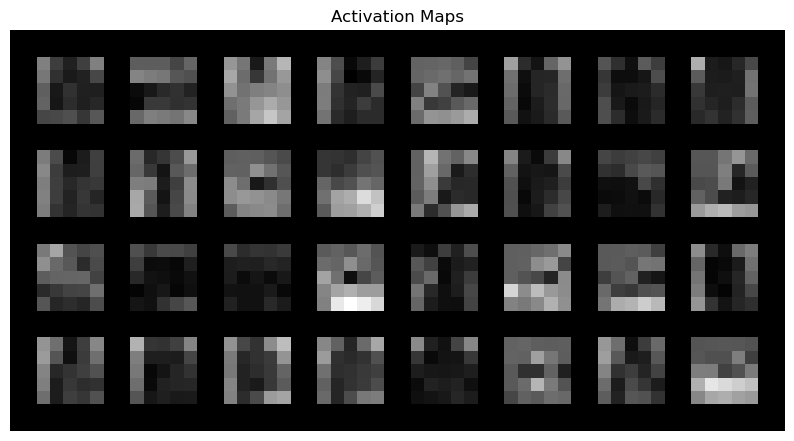

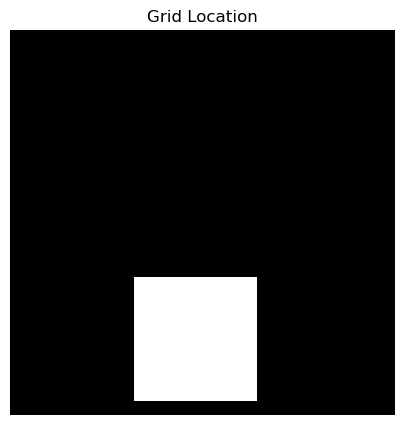

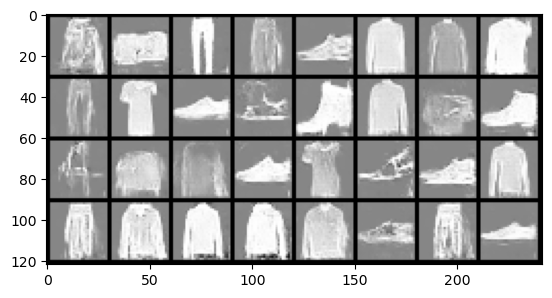

In [16]:
# load generator model and discriminator model
gen1 = Generator(input_dim=generator_input_dim).to(device)
gen1.load_state_dict(torch.load('best_models/gen_best.pth'))
gen1.eval()

disc1 = Discriminator(image_channel=discriminator_image_channel).to(device)
disc1.load_state_dict(torch.load('best_models/disc_best.pth'))
disc1.eval()

image_one_hot_labels = one_hot_labels[:, :, None, None]
image_one_hot_labels = image_one_hot_labels.repeat(
    1, 1, mnist_shape[1], mnist_shape[2]
)
fake_noise = create_noise_vector(32, z_dim, device=device)
print('fake_noise: ', fake_noise.shape)
noise_and_labels = concat_vectors(fake_noise, test_one_hot_labels)
fake = gen(noise_and_labels)
fake_image_and_labels = concat_vectors(fake, image_one_hot_labels)
disc_fake_pred = disc(fake_image_and_labels, return_activations=True)
visualize_activation_maps(disc_fake_pred)
visualize_grid_location(test_one_hot_labels[0].cpu())
plot_images_from_tensor(fake, num_images=32, nrow=8)